In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd drive/My\ Drive/DL/assgn1/Brain_segmentation_dataset
!ls

/content/drive/My Drive/DL/assgn1/Brain_segmentation_dataset
model_interpolation.pt	   model_strided_conv.pt  training
model_skip_connections.pt  model_trans_conv.pt	  validation


In [0]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap
from skimage.util import view_as_windows

In [0]:
def labels_to_mask(label):
  h=label.shape[0]
  w=label.shape[1]
  masks=np.zeros([h,w,4])    
  for r in range(h):
    for c in range(w):
      masks[r,c,label[r,c]]=1.0
  return masks

def masks_to_labels(masks):
  h=masks.shape[0]
  w=masks.shape[1]
  labels=np.zeros([h,w],dtype='int32')
  for c in range(4):
    for i in range(h):
      for j in range(w):
        if masks[i,j,c]==1:
          labels[i,j]=c
  return labels

def dice_coef(y_true,y_pred,smooth=1):
  numer=2*torch.sum(y_pred*y_true)
  denom=torch.sum(y_true+y_pred)
  coef=(numer+smooth)/(denom+smooth)
  return coef.item()

In [0]:
vol5x=scipy.io.loadmat('training/Vol_05_input.mat')
vol5gt=scipy.io.loadmat('training/Vol_05gt.mat')
vol2x=scipy.io.loadmat('training/Vol_02_input.mat')
vol2gt=scipy.io.loadmat('training/Vol_02gt.mat')
vol1x=scipy.io.loadmat('training/Vol_01_input.mat')
vol1gt=scipy.io.loadmat('training/Vol_01gt.mat')

x_train=np.concatenate((vol1x['ana'],vol2x['ana'],vol5x['ana']),axis=2)
y_train=np.concatenate((vol1gt['gt'],vol2gt['gt'],vol5gt['gt']),axis=2)
x_train=np.moveaxis(x_train,-1,0)
y_train=np.moveaxis(y_train,-1,0)

x_val=scipy.io.loadmat('validation/Vol_06_input.mat')
x_val=x_val['ana']
x_val=np.moveaxis(x_val,-1,0)
y_val=scipy.io.loadmat('validation/Vol_06gt.mat')
y_val=y_val['gt']
y_val=np.moveaxis(y_val,-1,0)

x_train=x_train/255.0
x_val=x_val/255.0
x_train=x_train.astype(np.float32)
x_val=x_val.astype(np.float32)
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

(768, 256, 128) (768, 256, 128) (256, 256, 128) (256, 256, 128)


In [0]:
idx_train=list(range(0,len(x_train)))
idx_train=np.array(idx_train)
np.random.shuffle(idx_train)

idx_val=list(range(0,len(x_val)))
idx_val=np.array(idx_val)
np.random.shuffle(idx_val)

In [0]:
colors=[(0,0,0),(1,0,0),(0,1,0),(0,0,1)]
cm=LinearSegmentedColormap.from_list('rgb_cmap',colors,N=4)

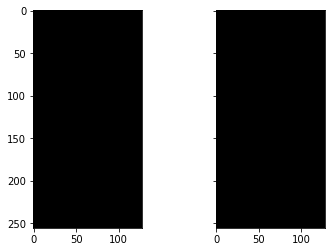

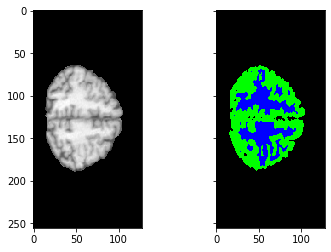

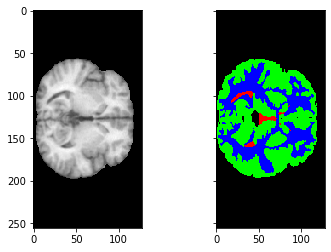

In [0]:
idx1=random.randint(0,len(x_train))
idx2=random.randint(0,len(x_train))
idx3=random.randint(0,len(x_train))
f1,(ax1,ax2)=plt.subplots(1,2,sharey=True)
ax1.imshow(x_train[idx_train[idx1],:,:],cmap='gray')
ax2.imshow(y_train[idx_train[idx1],:,:],cmap=cm)
f2,(ax1,ax2)=plt.subplots(1,2,sharey=True)
ax1.imshow(x_train[idx_train[idx2],:,:],cmap='gray')
ax2.imshow(y_train[idx_train[idx2],:,:],cmap=cm)
f3,(ax1,ax2)=plt.subplots(1,2,sharey=True)
ax1.imshow(x_train[idx_train[idx3],:,:],cmap='gray')
ax2.imshow(y_train[idx_train[idx3],:,:],cmap=cm)

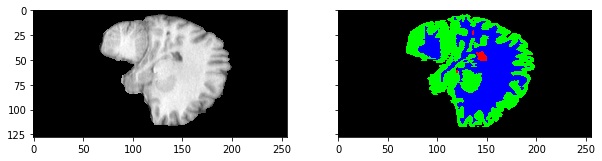

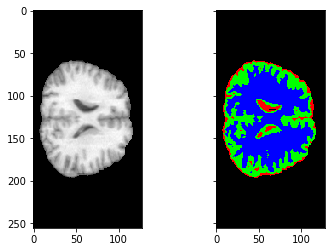

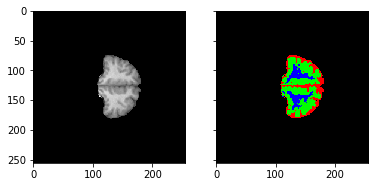

In [0]:
vol5x=scipy.io.loadmat('training/Vol_05_input.mat')['ana']
vol5gt=scipy.io.loadmat('training/Vol_05gt.mat')['gt']

f1,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(10,10))
ax1.imshow(vol5x[150,:,:],cmap='gray')
ax2.imshow(vol5gt[150,:,:],cmap=cm)

f1,(ax1,ax2)=plt.subplots(1,2,sharey=True)
ax1.imshow(vol5x[:,:,150],cmap='gray')
ax2.imshow(vol5x[:,:,150],cmap=cm)

f1,(ax1,ax2)=plt.subplots(1,2,sharey=True)
ax1.imshow(vol5x[:,100,:],cmap='gray')
ax2.imshow(vol5x[:,100,:],cmap=cm)

In [0]:
labels=[]
for i in range(len(y_train)):
  labels.append(labels_to_mask(y_train[i,:,:]))
y_train=np.array(labels)

labels=[]
for i in range(len(y_val)):
  labels.append(labels_to_mask(y_val[i,:,:]))
y_val=np.array(labels)

print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

(768, 256, 128) (768, 256, 128, 4) (256, 256, 128) (256, 256, 128, 4)


In [0]:
learning_rate=0.0001
epochs=15
batch_size=16
n_batches=int(len(x_train)/batch_size)

In [0]:
train_batches=[]
for i in range(n_batches):
  images=[]
  gt=[]
  for j in range(i*batch_size,(i+1)*batch_size):
    images.append(np.expand_dims(x_train[idx_train[j],:,:],axis=0))
    temp=y_train[idx_train[j],:,:,:]
    temp=np.moveaxis(temp,-1,0)
    gt.append(temp)
  batch={'images':torch.tensor(np.array(images,dtype=np.float32)),'gt':torch.tensor(np.array(gt,dtype=np.float32))}
  train_batches.append(batch)

val_batches=[]
for i in range(int(len(x_val)/batch_size)):
  v_images=[]
  v_gt=[]
  for j in range(i*batch_size,(i+1)*batch_size):
    v_images.append(np.expand_dims(x_val[idx_val[j],:,:],axis=0))
    temp=y_val[idx_val[j],:,:,:]
    temp=np.moveaxis(temp,-1,0)
    v_gt.append(temp)
  batch={'images':torch.tensor(np.array(v_images,dtype=np.float32)),'gt':torch.tensor(np.array(v_gt,dtype=np.float32))}
  val_batches.append(batch)

In [0]:
class SegNetWithInterpolation(nn.Module):
  def __init__(self):
    super(SegNetWithInterpolation,self).__init__()
    self.conv1_1=nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
    self.conv1_2=nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)

    self.conv2_1=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
    self.conv2_2=nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)

    self.conv3_1=nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
    self.conv3_2=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.conv3_3=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)

    self.conv4_1=nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1)
    self.conv4_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.conv4_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.conv5_1=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.conv5_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.conv5_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.upconv5_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv5_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv5_1=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.upconv4_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv4_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv4_1=nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)

    self.upconv3_3=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.upconv3_2=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.upconv3_1=nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1)

    self.upconv2_2=nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)
    self.upconv2_1=nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1)

    self.upconv1_2=nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)
    self.upconv1_1=nn.Conv2d(64,4,kernel_size=3,stride=1,padding=1)

    self.pool1=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
    self.pool2=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
    self.pool3=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
    self.pool4=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
    self.pool5=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)

    self.upsamp5=nn.MaxUnpool2d(kernel_size=2,stride=2)
    self.upsamp4=nn.MaxUnpool2d(kernel_size=2,stride=2)
    self.upsamp3=nn.MaxUnpool2d(kernel_size=2,stride=2)
    self.upsamp2=nn.MaxUnpool2d(kernel_size=2,stride=2)
    self.upsamp1=nn.MaxUnpool2d(kernel_size=2,stride=2)

    self.batch_norm_1=nn.BatchNorm2d(64)
    self.batch_norm_2=nn.BatchNorm2d(128)
    self.batch_norm_3=nn.BatchNorm2d(256)
    self.batch_norm_4=nn.BatchNorm2d(512)
  
  def forward(self,x):
    dim1=x.size()
    x=self.conv1_1(x)
    x=self.batch_norm_1(x)
    x=F.relu(x)
    x=self.conv1_2(x)
    x=self.batch_norm_1(x)
    x=F.relu(x)
    x,idx1=self.pool1(x)

    dim2=x.size()
    x=self.conv2_1(x)
    x=self.batch_norm_2(x)
    x=F.relu(x)
    x=self.conv2_2(x)
    x=self.batch_norm_2(x)
    x=F.relu(x)
    x,idx2=self.pool2(x)

    dim3=x.size()
    x=self.conv3_1(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.conv3_2(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.conv3_3(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x,idx3=self.pool3(x)

    dim4=x.size()
    x=self.conv4_1(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.conv4_2(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.conv4_3(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x,idx4=self.pool4(x)

    dim5=x.size()
    x=self.conv5_1(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.conv5_2(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.conv5_3(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x,idx5=self.pool5(x)    

    x=self.upsamp5(x,idx5,output_size=dim5)
    x=self.upconv5_3(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.upconv5_2(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.upconv5_1(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)

    x=self.upsamp4(x,idx4,output_size=dim4)
    x=self.upconv4_3(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.upconv4_2(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.upconv4_1(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)

    x=self.upsamp3(x,idx3,output_size=dim3)
    x=self.upconv3_3(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.upconv3_2(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.upconv3_1(x)
    x=self.batch_norm_2(x)
    x=F.relu(x)

    x=self.upsamp2(x,idx2,output_size=dim2)
    x=self.upconv2_2(x)
    x=self.batch_norm_2(x)
    x=F.relu(x)
    x=self.upconv2_1(x)
    x=self.batch_norm_1(x)
    x=F.relu(x)

    x=self.upsamp1(x,idx1,output_size=dim1)
    x=self.upconv1_2(x)
    x=self.batch_norm_1(x)
    x=F.relu(x)
    x=self.upconv1_1(x)
    x=F.softmax(x,dim=1)

    return x

class SegNetWithTransConv(nn.Module):
  def __init__(self):
    super(SegNetWithTransConv,self).__init__()
    self.conv1_1=nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
    self.conv1_2=nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)

    self.conv2_1=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
    self.conv2_2=nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)

    self.conv3_1=nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
    self.conv3_2=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.conv3_3=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)

    self.conv4_1=nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1)
    self.conv4_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.conv4_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.conv5_1=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.conv5_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.conv5_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.upconv5_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv5_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv5_1=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.upconv4_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv4_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv4_1=nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)

    self.upconv3_3=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.upconv3_2=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.upconv3_1=nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1)

    self.upconv2_2=nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)
    self.upconv2_1=nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1)

    self.upconv1_2=nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)
    self.upconv1_1=nn.Conv2d(64,4,kernel_size=3,stride=1,padding=1)

    self.pool1=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
    self.pool2=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
    self.pool3=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
    self.pool4=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
    self.pool5=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)

    self.upsamp5=nn.ConvTranspose2d(512,512,kernel_size=3,stride=2,padding=1)
    self.upsamp4=nn.ConvTranspose2d(512,512,kernel_size=3,stride=2,padding=1)
    self.upsamp3=nn.ConvTranspose2d(256,256,kernel_size=3,stride=2,padding=1)
    self.upsamp2=nn.ConvTranspose2d(128,128,kernel_size=3,stride=2,padding=1)
    self.upsamp1=nn.ConvTranspose2d(64,64,kernel_size=3,stride=2,padding=1)

    self.batch_norm_1=nn.BatchNorm2d(64)
    self.batch_norm_2=nn.BatchNorm2d(128)
    self.batch_norm_3=nn.BatchNorm2d(256)
    self.batch_norm_4=nn.BatchNorm2d(512)
  
  def forward(self,x):
    dim1=x.size()
    x=self.conv1_1(x)
    x=self.batch_norm_1(x)
    x=F.relu(x)
    x=self.conv1_2(x)
    x=self.batch_norm_1(x)
    x=F.relu(x)
    x,idx1=self.pool1(x)
    #64

    dim2=x.size()
    x=self.conv2_1(x)
    x=self.batch_norm_2(x)
    x=F.relu(x)
    x=self.conv2_2(x)
    x=self.batch_norm_2(x)
    x=F.relu(x)
    x,idx2=self.pool2(x)
    #128

    dim3=x.size()
    x=self.conv3_1(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.conv3_2(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.conv3_3(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x,idx3=self.pool3(x)
    #256

    dim4=x.size()
    x=self.conv4_1(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.conv4_2(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.conv4_3(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x,idx4=self.pool4(x)
    #512

    dim5=x.size()
    x=self.conv5_1(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.conv5_2(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.conv5_3(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x,idx5=self.pool5(x)
    #512    

    #512
    x=self.upsamp5(x,output_size=dim5)
    x=self.upconv5_3(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.upconv5_2(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.upconv5_1(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    #512

    #512
    x=self.upsamp4(x,output_size=dim4)
    x=self.upconv4_3(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.upconv4_2(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.upconv4_1(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    #256

    #256
    x=self.upsamp3(x,output_size=dim3)
    x=self.upconv3_3(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.upconv3_2(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.upconv3_1(x)
    x=self.batch_norm_2(x)
    x=F.relu(x)
    #128

    #128
    x=self.upsamp2(x,output_size=dim2)
    x=self.upconv2_2(x)
    x=self.batch_norm_2(x)
    x=F.relu(x)
    x=self.upconv2_1(x)
    x=self.batch_norm_1(x)
    x=F.relu(x)
    #64

    #64
    x=self.upsamp1(x,output_size=dim1)
    x=self.upconv1_2(x)
    x=self.batch_norm_1(x)
    x=F.relu(x)
    x=self.upconv1_1(x)
    x=F.softmax(x,dim=1)
    #3

    return x

class SegNetWithStridedConv(nn.Module):
  def __init__(self):
    super(SegNetWithStridedConv,self).__init__()
    self.conv1_1=nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
    self.conv1_2=nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)

    self.conv2_1=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
    self.conv2_2=nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)

    self.conv3_1=nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
    self.conv3_2=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.conv3_3=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)

    self.conv4_1=nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1)
    self.conv4_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.conv4_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.conv5_1=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.conv5_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.conv5_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.upconv5_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv5_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv5_1=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.upconv4_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv4_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv4_1=nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)

    self.upconv3_3=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.upconv3_2=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.upconv3_1=nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1)

    self.upconv2_2=nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)
    self.upconv2_1=nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1)

    self.upconv1_2=nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)
    self.upconv1_1=nn.Conv2d(64,4,kernel_size=3,stride=1,padding=1)

    self.downsamp1=nn.Conv2d(64,64,kernel_size=4,stride=2,padding=1)
    self.downsamp2=nn.Conv2d(128,128,kernel_size=4,stride=2,padding=1)
    self.downsamp3=nn.Conv2d(256,256,kernel_size=4,stride=2,padding=1)
    self.downsamp4=nn.Conv2d(512,512,kernel_size=4,stride=2,padding=1)
    self.downsamp5=nn.Conv2d(512,512,kernel_size=4,stride=2,padding=1)

    self.upsamp5=nn.ConvTranspose2d(512,512,kernel_size=3,stride=2,padding=1)
    self.upsamp4=nn.ConvTranspose2d(512,512,kernel_size=3,stride=2,padding=1)
    self.upsamp3=nn.ConvTranspose2d(256,256,kernel_size=3,stride=2,padding=1)
    self.upsamp2=nn.ConvTranspose2d(128,128,kernel_size=3,stride=2,padding=1)
    self.upsamp1=nn.ConvTranspose2d(64,64,kernel_size=3,stride=2,padding=1)

    self.batch_norm_1=nn.BatchNorm2d(64)
    self.batch_norm_2=nn.BatchNorm2d(128)
    self.batch_norm_3=nn.BatchNorm2d(256)
    self.batch_norm_4=nn.BatchNorm2d(512)
  
  def forward(self,x):
    dim1=x.size()
    x=self.conv1_1(x)
    x=self.batch_norm_1(x)
    x=F.relu(x)
    x=self.conv1_2(x)
    x=self.batch_norm_1(x)
    x=F.relu(x)
    x=self.downsamp1(x)
    #64

    dim2=x.size()
    x=self.conv2_1(x)
    x=self.batch_norm_2(x)
    x=F.relu(x)
    x=self.conv2_2(x)
    x=self.batch_norm_2(x)
    x=F.relu(x)
    x=self.downsamp2(x)
    #128

    dim3=x.size()
    x=self.conv3_1(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.conv3_2(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.conv3_3(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.downsamp3(x)
    #256

    dim4=x.size()
    x=self.conv4_1(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.conv4_2(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.conv4_3(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.downsamp4(x)
    #512

    dim5=x.size()
    x=self.conv5_1(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.conv5_2(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.conv5_3(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.downsamp5(x)
    #512    

    #512
    x=self.upsamp5(x,output_size=dim5)
    x=self.upconv5_3(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.upconv5_2(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.upconv5_1(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    #512

    #512
    x=self.upsamp4(x,output_size=dim4)
    x=self.upconv4_3(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.upconv4_2(x)
    x=self.batch_norm_4(x)
    x=F.relu(x)
    x=self.upconv4_1(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    #256

    #256
    x=self.upsamp3(x,output_size=dim3)
    x=self.upconv3_3(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.upconv3_2(x)
    x=self.batch_norm_3(x)
    x=F.relu(x)
    x=self.upconv3_1(x)
    x=self.batch_norm_2(x)
    x=F.relu(x)
    #128

    #128
    x=self.upsamp2(x,output_size=dim2)
    x=self.upconv2_2(x)
    x=self.batch_norm_2(x)
    x=F.relu(x)
    x=self.upconv2_1(x)
    x=self.batch_norm_1(x)
    x=F.relu(x)
    #64

    #64
    x=self.upsamp1(x,output_size=dim1)
    x=self.upconv1_2(x)
    x=self.batch_norm_1(x)
    x=F.relu(x)
    x=self.upconv1_1(x)
    x=F.softmax(x,dim=1)
    #3

    return x

class SegNetWithSkipConnections(nn.Module):
  def __init__(self):
    super(SegNetWithSkipConnections,self).__init__()
    self.conv1_1=nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
    self.conv1_2=nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)

    self.conv2_1=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
    self.conv2_2=nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)

    self.conv3_1=nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
    self.conv3_2=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.conv3_3=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)

    self.conv4_1=nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1)
    self.conv4_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.conv4_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.conv5_1=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.conv5_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.conv5_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.upconv5_3=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv5_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv5_1=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)

    self.upconv4_3=nn.Conv2d(1024,512,kernel_size=3,stride=1,padding=1)
    self.upconv4_2=nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.upconv4_1=nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)

    self.upconv3_3=nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)
    self.upconv3_2=nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.upconv3_1=nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1)

    self.upconv2_2=nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1)
    self.upconv2_1=nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1)

    self.upconv1_2=nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1)
    self.upconv1_1=nn.Conv2d(64,4,kernel_size=3,stride=1,padding=1)

    self.pool1=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
    self.pool2=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
    self.pool3=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
    self.pool4=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
    self.pool5=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)

    self.upsamp5=nn.MaxUnpool2d(kernel_size=2,stride=2)
    self.upsamp4=nn.MaxUnpool2d(kernel_size=2,stride=2)
    self.upsamp3=nn.MaxUnpool2d(kernel_size=2,stride=2)
    self.upsamp2=nn.MaxUnpool2d(kernel_size=2,stride=2)
    self.upsamp1=nn.MaxUnpool2d(kernel_size=2,stride=2)

    self.batch_norm_1=nn.BatchNorm2d(64)
    self.batch_norm_2=nn.BatchNorm2d(128)
    self.batch_norm_3=nn.BatchNorm2d(256)
    self.batch_norm_4=nn.BatchNorm2d(512)
  
  def forward(self,x):
    #1,1
    dim1=x.size()
    x1=self.conv1_1(x)
    x1=self.batch_norm_1(x1)
    x1=F.relu(x1)
    x1=self.conv1_2(x1)
    x1=self.batch_norm_1(x1)
    x1=F.relu(x1)
    p1,idx1=self.pool1(x1)
    #64,1/2

    #64,1/2
    dim2=p1.size()
    x2=self.conv2_1(p1)
    x2=self.batch_norm_2(x2)
    x2=F.relu(x2)
    x2=self.conv2_2(x2)
    x2=self.batch_norm_2(x2)
    x2=F.relu(x2)
    p2,idx2=self.pool2(x2)
    #128,1/4

    #128,1/4
    dim3=p2.size()
    x3=self.conv3_1(p2)
    x3=self.batch_norm_3(x3)
    x3=F.relu(x3)
    x3=self.conv3_2(x3)
    x3=self.batch_norm_3(x3)
    x3=F.relu(x3)
    x3=self.conv3_3(x3)
    x3=self.batch_norm_3(x3)
    x3=F.relu(x3)
    p3,idx3=self.pool3(x3)
    #256,1/8

    #256,1/8
    dim4=p3.size()
    x4=self.conv4_1(p3)
    x4=self.batch_norm_4(x4)
    x4=F.relu(x4)
    x4=self.conv4_2(x4)
    x4=self.batch_norm_4(x4)
    x4=F.relu(x4)
    x4=self.conv4_3(x4)
    x4=self.batch_norm_4(x4)
    x4=F.relu(x4)
    p4,idx4=self.pool4(x4)
    #512,1/16

    #512,1/16
    dim5=p4.size()
    x5=self.conv5_1(p4)
    x5=self.batch_norm_4(x5)
    x5=F.relu(x5)
    x5=self.conv5_2(x5)
    x5=self.batch_norm_4(x5)
    x5=F.relu(x5)
    x5=self.conv5_3(x5)
    x5=self.batch_norm_4(x5)
    x5=F.relu(x5)
    p5,idx5=self.pool5(x5)
    #512,1/32   

    #512,1/32
    u5=self.upsamp5(p5,idx5,output_size=dim5)
    u5=self.upconv5_3(u5)
    u5=self.batch_norm_4(u5)
    u5=F.relu(u5)
    u5=self.upconv5_2(u5)
    u5=self.batch_norm_4(u5)
    u5=F.relu(u5)
    u5=self.upconv5_1(u5)
    u5=self.batch_norm_4(u5)
    u5=F.relu(u5)
    #512,1/16

    #512,1/16
    u4=self.upsamp4(u5,idx4,output_size=dim4)
    u4=torch.cat([u4,x4],dim=1)
    u4=self.upconv4_3(u4)
    u4=self.batch_norm_4(u4)
    u4=F.relu(u4)
    u4=self.upconv4_2(u4)
    u4=self.batch_norm_4(u4)
    u4=F.relu(u4)
    u4=self.upconv4_1(u4)
    u4=self.batch_norm_3(u4)
    u4=F.relu(u4)
    #256,1/8

    #256,1/8
    u3=self.upsamp3(u4,idx3,output_size=dim3)
    u3=torch.cat([u3,x3],dim=1)
    u3=self.upconv3_3(u3)
    u3=self.batch_norm_3(u3)
    u3=F.relu(u3)
    u3=self.upconv3_2(u3)
    u3=self.batch_norm_3(u3)
    u3=F.relu(u3)
    u3=self.upconv3_1(u3)
    u3=self.batch_norm_2(u3)
    u3=F.relu(u3)
    #128,1/4

    #128,1/4
    u2=self.upsamp2(u3,idx2,output_size=dim2)
    u2=torch.cat([u2,x2],dim=1)
    u2=self.upconv2_2(u2)
    u2=self.batch_norm_2(u2)
    u2=F.relu(u2)
    u2=self.upconv2_1(u2)
    u2=self.batch_norm_1(u2)
    u2=F.relu(u2)
    #64,1/2

    #64,1/2
    u1=self.upsamp1(u2,idx1,output_size=dim1)
    u1=torch.cat([u1,x1],dim=1)
    u1=self.upconv1_2(u1)
    u1=self.batch_norm_1(u1)
    u1=F.relu(u1)
    u1=self.upconv1_1(u1)
    u1=F.softmax(u1,dim=1)
    #4,1

    return u1

In [0]:
# model=SegNetWithInterpolation()
# model=SegNetWithTransConv()
# model=SegNetWithStridedConv()
model=SegNetWithSkipConnections()
model.cuda()
criterion=nn.BCELoss()
optimiser=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [0]:
train_loss_list=[]
val_loss_list=[]
train_dice_coef_list=[]
val_dice_coef_list=[]
for epoch in range(epochs):
  train_loss=0
  train_dice=0
  for i in range(len(train_batches)):
    batch=train_batches[i]
    images=batch['images']
    gt=batch['gt']
    pred=model(images.cuda())
    optimiser.zero_grad()
    loss=criterion(pred,gt.cuda())
    train_loss+=loss.item()
    loss.backward()
    optimiser.step()
    for k in range(batch_size):
      coef=dice_coef(gt[k,:,:,:],pred[k,:,:,:].cpu())
      train_dice+=coef
  avg_loss=train_loss/len(train_batches)
  train_loss_list.append(avg_loss)
  avg_train_dice_coef=train_dice/len(x_train)
  train_dice_coef_list.append(avg_train_dice_coef)

  val_loss=0
  val_dice=0
  for i in range(len(val_batches)):
    batch=val_batches[i]
    images=batch['images']
    gt=batch['gt']
    pred=model(images.cuda())
    loss=criterion(pred,gt.cuda())
    val_loss+=loss.item()
    for k in range(batch_size):
      coef=dice_coef(gt[k,:,:,:],pred[k,:,:,:].cpu())
      val_dice+=coef
  avg_val_loss=val_loss/len(val_batches)
  val_loss_list.append(avg_val_loss)
  avg_val_dice_coef=val_dice/len(x_val)
  val_dice_coef_list.append(avg_val_dice_coef)
  print('Epoch:',(epoch+1),'/',epochs,'loss:',avg_loss,'dice_coef:',avg_train_dice_coef,'val_loss:',avg_val_loss,'val_dice_coef:',avg_val_dice_coef)

Epoch: 1 / 15 loss: 0.33156997213761014 dice_coef: 0.49794381325288367 val_loss: 0.17674805875867605 val_dice_coef: 0.7009045998565853
Epoch: 2 / 15 loss: 0.09602050149502854 dice_coef: 0.8347586401893446 val_loss: 0.05870966077782214 val_dice_coef: 0.9035798313561827
Epoch: 3 / 15 loss: 0.043498517479747534 dice_coef: 0.9300167043693364 val_loss: 0.0400113039650023 val_dice_coef: 0.9398886244744062
Epoch: 4 / 15 loss: 0.03110387991182506 dice_coef: 0.9525026288659623 val_loss: 0.034097591415047646 val_dice_coef: 0.9528591586276889
Epoch: 5 / 15 loss: 0.025309631096509595 dice_coef: 0.9626138977861652 val_loss: 0.029352964949794114 val_dice_coef: 0.9609684348106384
Epoch: 6 / 15 loss: 0.02170663505482177 dice_coef: 0.968637906635801 val_loss: 0.026717481552623212 val_dice_coef: 0.9656968421768397
Epoch: 7 / 15 loss: 0.019214458918819826 dice_coef: 0.9727078073192388 val_loss: 0.024547449429519475 val_dice_coef: 0.9692689999938011
Epoch: 8 / 15 loss: 0.017332175416716684 dice_coef: 0.97

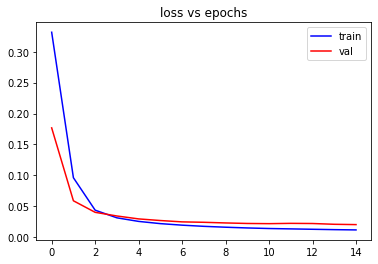

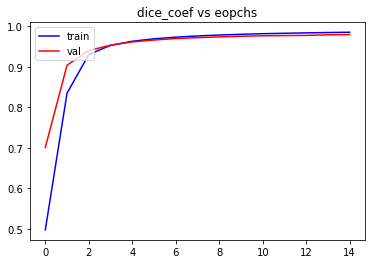

In [0]:
plt.figure()
plt.title('loss vs epochs')
plt.plot(train_loss_list,'b',label='train')
plt.plot(val_loss_list,'r',label='val')
plt.legend(loc='upper right')

plt.figure()
plt.title('dice_coef vs eopchs')
plt.plot(train_dice_coef_list,'b',label='train')
plt.plot(val_dice_coef_list,'r',label='val')
plt.legend(loc='upper left')

plt.show()

In [0]:
torch.save(model.state_dict(),'/content/drive/My Drive/DL/assgn1/Brain_segmentation_dataset/model_skip_connections.pt')

In [0]:
model=SegNetWithSkipConnections()
model.cuda()
model.load_state_dict(torch.load('/content/drive/My Drive/DL/assgn1/Brain_segmentation_dataset/model_skip_connections.pt'))
val_preds=[]
for i in range(len(val_batches)):
  batch=val_batches[i]
  images=batch['images']
  gt=batch['gt']
  pred=model(images.cuda())
  pred=pred.cpu().data.numpy()
  pred=np.moveaxis(pred,1,-1)
  pred=pred.round().astype(int)
  val_preds.append(pred)

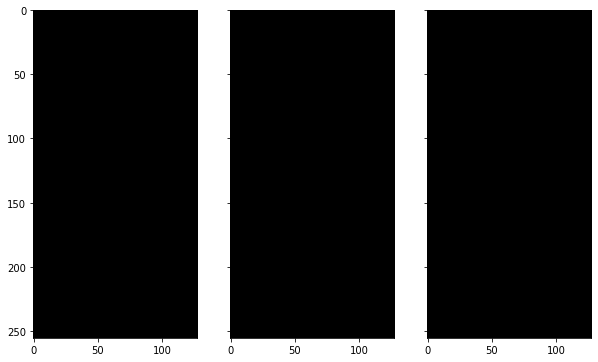

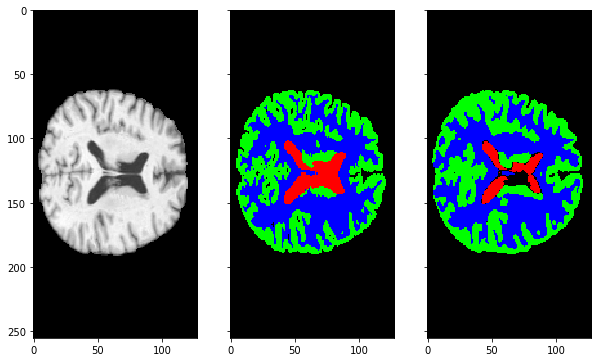

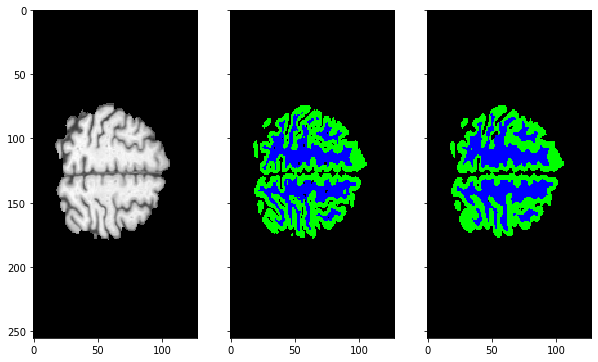

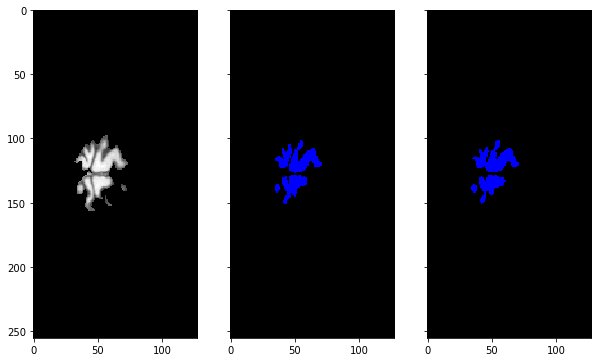

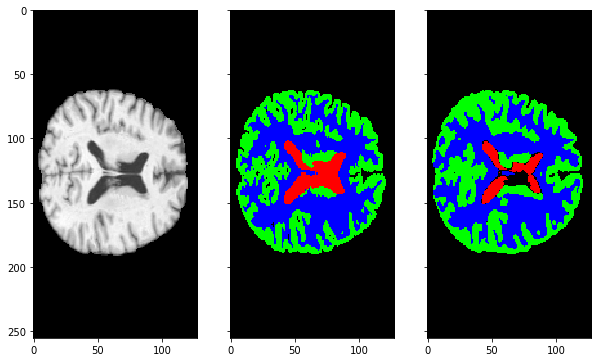

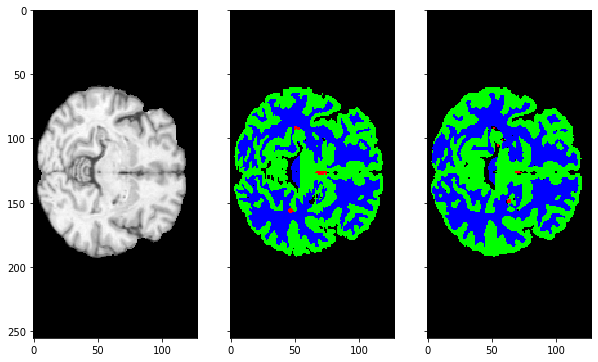

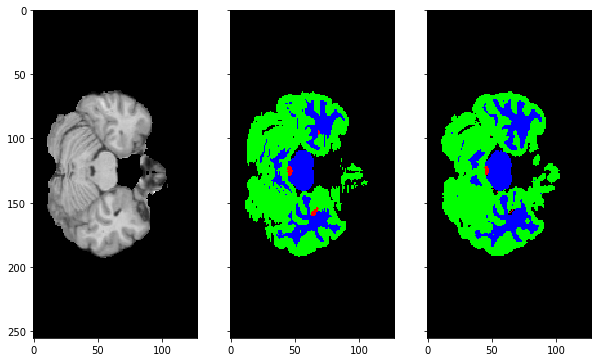

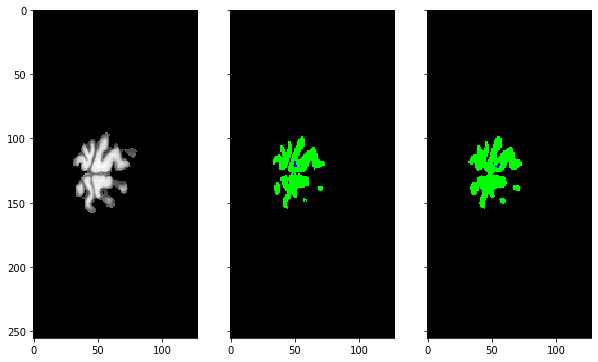

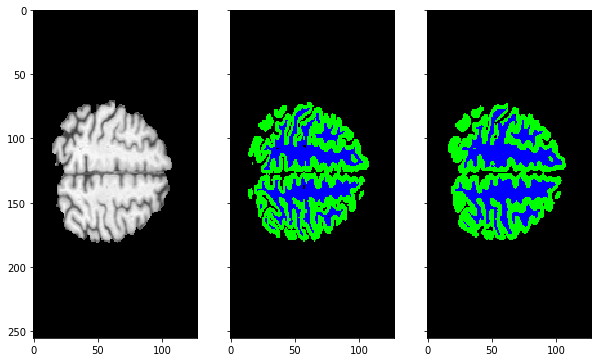

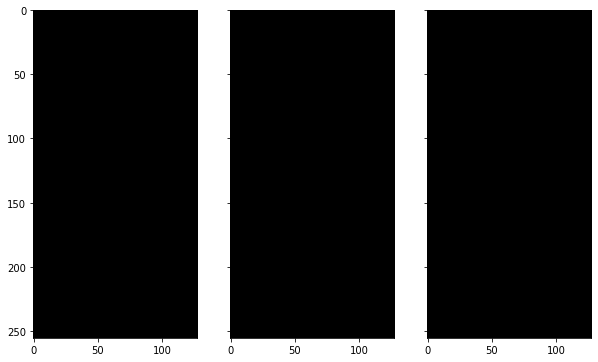

In [0]:
for i in range(10):
  batch_num=random.randint(0,len(val_batches)-1)
  image_num=random.randint(0,batch_size-1)
  batch=val_batches[batch_num]
  imgs=batch['images'].cpu().data.numpy()
  imgs=np.moveaxis(imgs,1,-1)
  gt=batch['gt'].cpu().data.numpy()
  gt=np.moveaxis(gt,1,-1)
  pred_mask=val_preds[batch_num][image_num,:,:,:]
  pred_labels=masks_to_labels(pred_mask)
  gt=masks_to_labels(gt[image_num,:,:,:])

  f1,(ax1,ax2,ax3)=plt.subplots(1,3,sharey=True,figsize=(10,10))
  ax1.imshow(imgs[image_num,:,:,0],cmap='gray')
  ax2.imshow(gt,cmap=cm)
  ax3.imshow(pred_labels,cmap=cm)